## General Stats

In [1]:
from os.path import join
import json
from collections import defaultdict
with open(join('translations', 'info.json'), 'r') as f:
    prefix2file = json.load(f)
    
procs = [f'proc{i}' for i in range(1, 7)]

total_time = defaultdict(int)

for proc in procs:
    for prefix, info in prefix2file.items():
        if info.get('procedure', None) == proc:
            duration = info['log']['end'] - info['log']['start']
            if proc == 'proc1':
                tl = info['task']['translator']
                if tl == 'deepl_document':
                    key = f'proc1-deepl'
                else:
                    key = f'proc1-gpt'
            else:
                key = proc
            total_time[key] += duration

* Procedure 2+3 covered EuroParl, Procedure 4 FLORES+
* Similar dataset sizes, however Proc2/3 used request-response, Proc4 used streaming


In [2]:
print(f'Proc2+3: {(total_time['proc2']+total_time['proc3'])/60:.2f}min')
print(f'Proc4: {(total_time['proc4'])/60:.2f}min')

Proc2+3: 329.68min
Proc4: 272.38min


* Note, these times account for automatic retries, since we removed adjusted the times based on the DEBUG logs. 
* So despite this adjustment, the streaming variant was still faster.

In [3]:
print(f'DeepL: {(total_time['proc1-deepl']+total_time['proc6'])/60:.2f}min')
print(f'GPT: {(total_time['proc1-gpt']+total_time['proc2']+total_time['proc3']+total_time['proc4'])/60:.2f}min')

DeepL: 46.48min
GPT: 748.00min


* For the same workload, GPT took in total roughly 16 times as much as DeepL
    * Excluding the manual retries from Proc5

# Exploiting Existing Systems
* To take advantage of code that we already have for correlations and visualizations, we can pretend that certain attributes that we are interested in are equivalent to metrics such as BLEU score.

In [4]:
from os.path import join
import pandas as pd
import json

time2df = {}

parts = ['ep-gpt', 'ep-deepl', 'flores-gpt',
         'flores-deepl', 'opus-gpt', 'opus-deepl']

with open(join('translations', 'info.json'), 'r') as f:
    prefix2file = json.load(f)

for part in parts:
    data = {'Label': [], 'Time': [], 'Size': []}
    for prefix, info in prefix2file.items():
        if prefix.startswith(part):
            src_lang, tgt_lang = prefix.split('-')[2], prefix.split('-')[3]
            duration = info['log']['end'] - info['log']['start']
            data['Label'].append(f'{src_lang}-{tgt_lang}')
            data['Time'].append(duration)
            if part.endswith('gpt'):
                data['Size'].append(info['log']['out_model_tokens'])
            if part.endswith('deepl'):
                data['Size'].append(info['log']['out_tokens'])

    df = pd.DataFrame(data)
    time2df[part] = df

In [5]:
for k in time2df:
    print(k, len(time2df[k]))

ep-gpt 110
ep-deepl 110
flores-gpt 110
flores-deepl 110
opus-gpt 20
opus-deepl 20


In [6]:
import os
import pandas as pd
from os.path import join
files = os.listdir('post_results')
res2df = {}
for fi in files:
    df = pd.read_csv(join('post_results', fi))
    res2df[fi.replace('.csv', '')] = df

In [7]:
for k in res2df:
    print(k, len(res2df[k]))

ep-deepl 110
ep-gpt 110
flores-deepl 110
flores-gpt 110
opus-deepl 20
opus-gpt 20


In [8]:
new = {}
for k in res2df:
    df1 = res2df[k]
    df2 = time2df[k]
    df3 = pd.merge(df1, df2, on='Label')
    new[k] = df3

In [9]:
os.makedirs('enriched_results', exist_ok=True)
for k in new:
    df = new[k]
    df.to_csv(join('enriched_results', f'{k}.csv'))

## Time Analysis

In [10]:
from scripts.presentation import Presenter
results_folder = 'enriched_results'
p = Presenter(results_folder=results_folder, metrics=['BLEU', 'chrF', 'Time', 'Size'])

In [11]:
keys = ['ep-gpt', 'flores-gpt', 'opus-gpt', 'ep-deepl', 'flores-deepl', 'opus-deepl']
for key in keys:
    p.show_correlations(key1=key, key2=key, metric1='Time', metric2='Size')

Keys: ep-gpt : ep-gpt
Metrics: Time : Size
Pearson correlation: 0.49 (p = 4.5e-08)
Spearman correlation: 0.52 (p = 4.6e-09)

Keys: flores-gpt : flores-gpt
Metrics: Time : Size
Pearson correlation: 0.58 (p = 2.0e-11)
Spearman correlation: 0.55 (p = 3.4e-10)

Keys: opus-gpt : opus-gpt
Metrics: Time : Size
Pearson correlation: 0.68 (p = 9.9e-04)
Spearman correlation: 0.58 (p = 7.2e-03)

Keys: ep-deepl : ep-deepl
Metrics: Time : Size
Pearson correlation: 0.20 (p = 4.1e-02)
Spearman correlation: 0.24 (p = 1.0e-02)

Keys: flores-deepl : flores-deepl
Metrics: Time : Size
Pearson correlation: 0.32 (p = 8.0e-04)
Spearman correlation: 0.42 (p = 3.8e-06)

Keys: opus-deepl : opus-deepl
Metrics: Time : Size
Pearson correlation: -0.20 (p = 4.0e-01)
Spearman correlation: -0.10 (p = 6.8e-01)



In [12]:
keys = ['ep-gpt', 'flores-gpt', 'opus-gpt', 'ep-deepl', 'flores-deepl', 'opus-deepl']
for key in keys:
    p.show_correlations(key1=key, key2=key, metric1='BLEU', metric2='Time')

Keys: ep-gpt : ep-gpt
Metrics: BLEU : Time
Pearson correlation: -0.47 (p = 2.3e-07)
Spearman correlation: -0.45 (p = 6.9e-07)

Keys: flores-gpt : flores-gpt
Metrics: BLEU : Time
Pearson correlation: -0.28 (p = 2.9e-03)
Spearman correlation: -0.26 (p = 5.3e-03)

Keys: opus-gpt : opus-gpt
Metrics: BLEU : Time
Pearson correlation: -0.47 (p = 3.8e-02)
Spearman correlation: -0.32 (p = 1.7e-01)

Keys: ep-deepl : ep-deepl
Metrics: BLEU : Time
Pearson correlation: -0.16 (p = 9.4e-02)
Spearman correlation: -0.12 (p = 2.0e-01)

Keys: flores-deepl : flores-deepl
Metrics: BLEU : Time
Pearson correlation: -0.32 (p = 5.4e-04)
Spearman correlation: -0.40 (p = 1.5e-05)

Keys: opus-deepl : opus-deepl
Metrics: BLEU : Time
Pearson correlation: 0.39 (p = 9.0e-02)
Spearman correlation: 0.38 (p = 9.9e-02)



ep-gpt


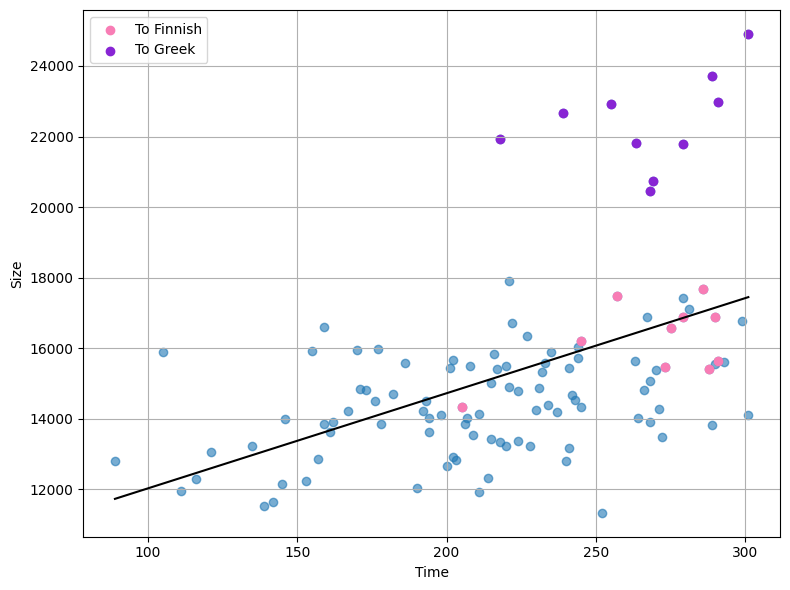

In [13]:
keys = ['ep-gpt']
for key in keys:
    x_vals, y_vals, model, labels = p.prep_lin_reg_1(
        key1=key, key2=key, metric1='Time', metric2='Size')
    mark_func = p.mark_by_language_direction(
        labels=labels, x_vals=x_vals, y_vals=y_vals, to_langs=[('fi', "#F87DB5"), ('el', "#8825D4")])


    print(key)
    p.basic_linear_regression(
        x_vals, y_vals, x_label='Time', y_label='Size', model=model, mark_func=mark_func)

In [14]:
from scripts.presentation import lang_freq
outliers = p.analyse_residuals(
    x_vals=x_vals, y_vals=y_vals, model=model, top_n=20, labels=labels)

_ = lang_freq(outliers)  # looks for the top 3 most frequent languages
for k, v in _.items():
    print(f'{k:<10}{v}')

fi-de 241.00, 13168.00
da-pt 214.00, 12334.00
es-it 159.00, 16589.00
el-en 240.00, 12790.00
de-pt 211.00, 11919.00
fr-de 272.00, 13495.00
fr-nl 289.00, 13831.00
fi-nl 301.00, 14101.00
en-sv 105.00, 15881.00
sv-el 268.01, 20468.00
de-el 269.00, 20746.00
de-en 252.00, 11335.00
da-el 279.00, 21774.00
fi-el 263.32, 21806.00
fr-el 291.00, 22969.00
pt-el 289.00, 23709.00
nl-el 218.00, 21924.00
es-el 255.00, 22927.00
en-el 239.00, 22663.00
it-el 301.00, 24907.00
to-el     10
from-fi   3
from-de   3
from-fr   3
to-de     2
to-pt     2
from-da   2
from-es   2
to-en     2
to-nl     2
from-en   2
to-it     1
from-el   1
to-sv     1
from-sv   1
from-pt   1
from-nl   1
from-it   1


* A positive relationship between Time and number of output tokens seems reasonable
* Explains why Greek was the one that was involved with the most timeout errors


ep-gpt


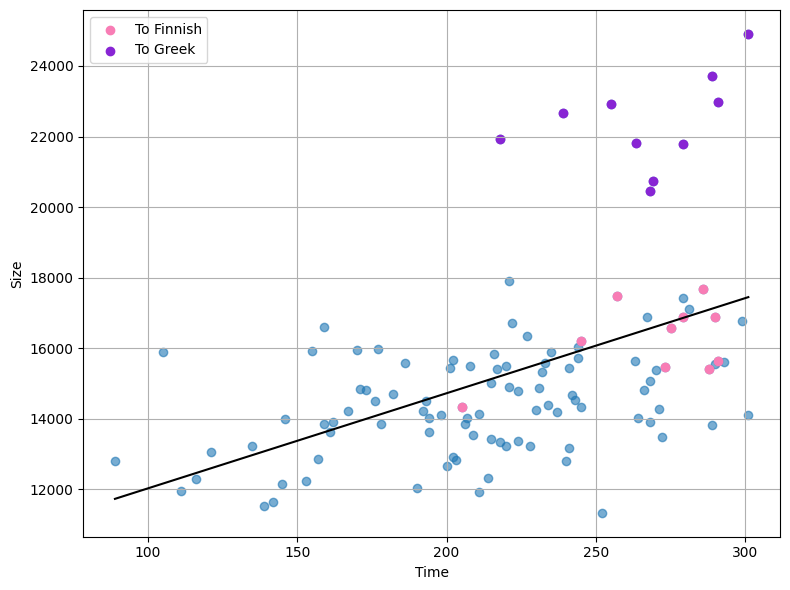

flores-deepl


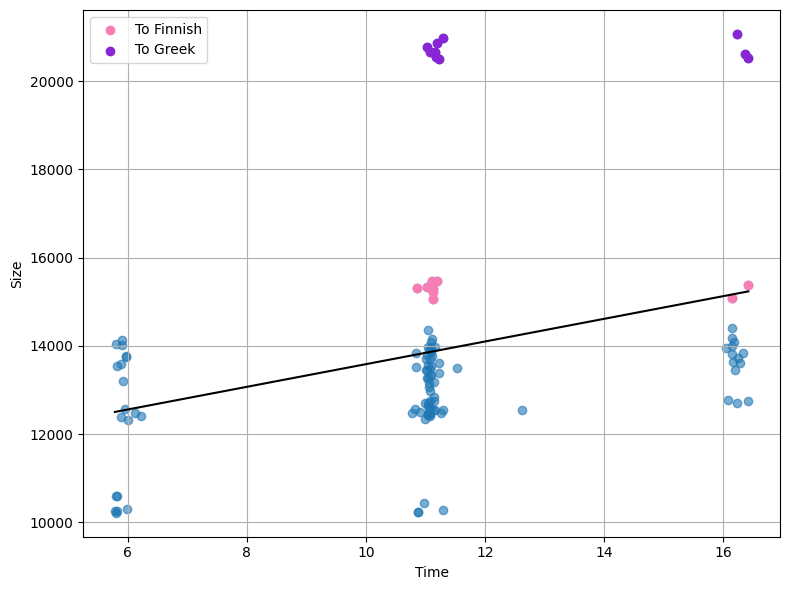

In [15]:
keys = ['ep-gpt', 'flores-deepl']
for key in keys:
    x_vals, y_vals, model, labels = p.prep_lin_reg_1(
        key1=key, key2=key, metric1='Time', metric2='Size')
    mark_func = p.mark_by_language_direction(
        labels=labels, x_vals=x_vals, y_vals=y_vals, to_langs=[('fi', "#F87DB5"), ('el', "#8825D4")])


    print(key)
    p.basic_linear_regression(
        x_vals, y_vals, x_label='Time', y_label='Size', model=model, mark_func=mark_func)

* A relationship between time and scores for DeepL is unlikely, it rather seems to be related to how DeepL's code has fixed delays, which explain these rather regular patterns, the fixed delay is 5 seconds
* As for GPT, a negative correlation implies that for translations that have higher BLEU scores, it took less time, or for translations that took longer to process, it had lower BLEU scores.